In [1]:

# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-u6tggpoy
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-u6tggpoy
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=99a0a6f59286dc213e4c9300d4b96edfd54d5ea2c0fb1c2168adce31b1fa150a
  Stored in directory: /tmp/pip-ephem-wheel-cache-8jvpru9_/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [3]:

!unzip /content/drive/MyDrive/leukemia/DS.zip


Streaming output truncated to the last 5000 lines.
  inflating: Original/Pre/WBC-Malignant-Pre-024.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-025.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-026.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-027.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-028.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-029.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-030.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-031.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-032.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-033.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-034.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-035.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-036.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-037.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-038.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-039.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-040.jpg  
  inflating: Original/Pre/WBC-M

In [4]:
import os
import numpy as np
from PIL import Image
import glob


In [ ]:
import os
import glob
import numpy as np
from PIL import Image


image_folder = "/content/Original/Pro"
mask_folder = "/content/Segmented/Pro/"

image_files = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))
mask_files = sorted(glob.glob(os.path.join(mask_folder, "*.jpg")))



Image stack shape: (804, 768, 1024)
Mask stack shape: (804, 768, 1024, 3)
Unique values in masks: [0 1]


In [ ]:

patch_size = 256
step = 256


In [ ]:
from patchify import patchify
import numpy as np

patch_size = 256  
step = 256  


all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]

   
    if len(large_image.shape) == 3:
        large_image = large_image[:, :, 0]  

    patches_img = patchify(large_image, (patch_size, patch_size), step=step)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)


all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]

    
    if len(large_mask.shape) == 3:
        large_mask = large_mask[:, :, 0]

    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]

            
            single_patch_mask = (single_patch_mask > 0).astype(np.uint8)

            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)


print("Patched images shape:", images.shape)  
print("Patched masks shape:", masks.shape)   
print("Unique mask values:", np.unique(masks))  



Patched images shape: (9648, 256, 256)
Patched masks shape: (9648, 256, 256)
Unique mask values: [0 1]


In [ ]:

valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)


Image shape: (6968, 256, 256)
Mask shape: (6968, 256, 256)


In [9]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


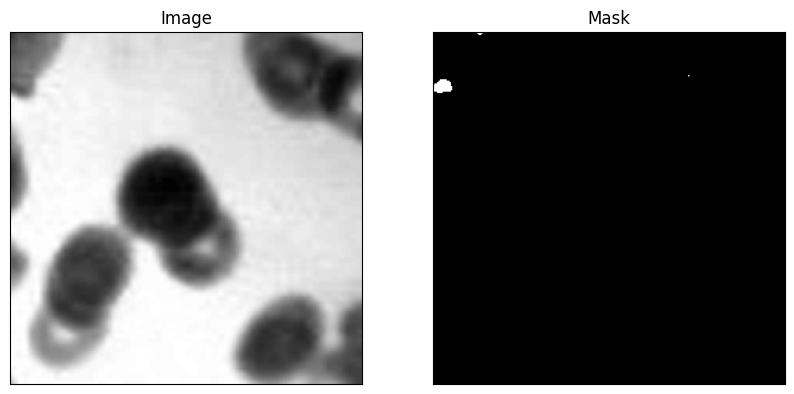

In [13]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


In [14]:

#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox


from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs


In [15]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [16]:
#Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)
#

In [17]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [18]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)


In [19]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)


pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [20]:

batch["ground_truth_mask"].shape


torch.Size([2, 256, 256])

In [21]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [23]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')


In [24]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [25]:
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


100%|██████████| 3484/3484 [53:17<00:00,  1.09it/s]

EPOCH: 0
Mean loss: 0.7695265513353999


In [26]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/leukemia/leukemia_Seg.pth")

In [28]:

from transformers import SamModel, SamConfig, SamProcessor
import torch
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/leukemia/leukemia_Seg.pth"))


<ipython-input-28-d16dbf902c7e>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/leukemia/leukemia_Seg.pth"

<All keys matched successfully>

In [29]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

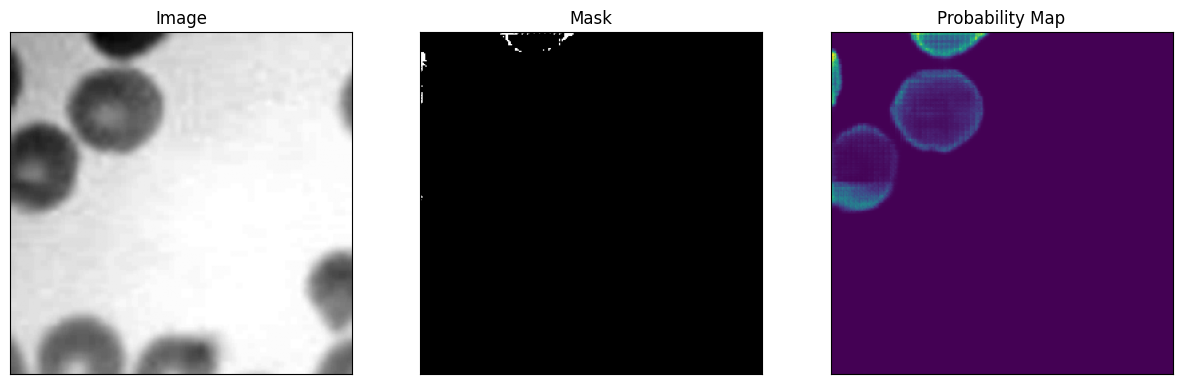

In [45]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [37]:
#Apply a trained model on large image
#large_test_images = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/small_dataset_for_training/images/12_training_mito_images.tif")
large_test_image = large_images[2]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap

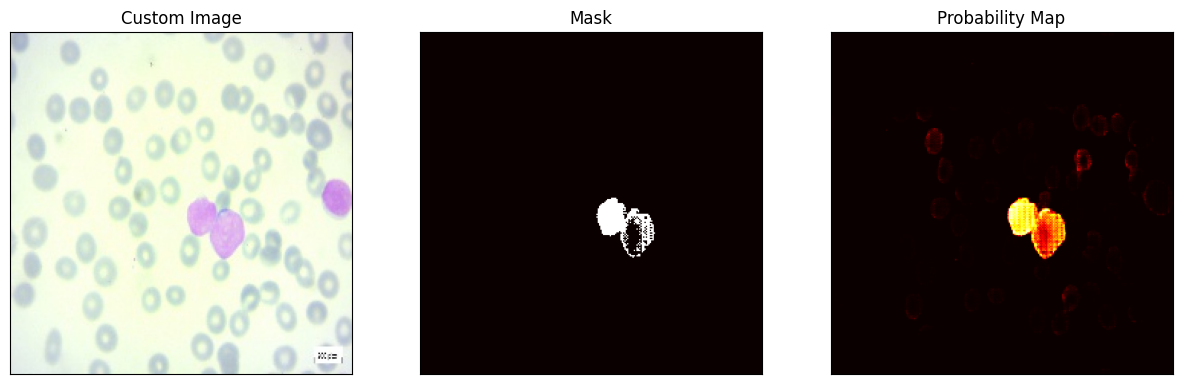

In [54]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Load custom image
image_path = "/content/Original/Pro/WBC-Malignant-Pro-003.jpg"  # Replace with the path to your image
test_image = Image.open(image_path).convert("RGB")  # Ensure it's in RGB format

# Convert to numpy array if needed
test_image_np = np.array(test_image)

# Manually define a bounding box or generate it from some mask
# Example bounding box format: [x_min, y_min, x_max, y_max]
prompt = [50, 50, 200, 200]  # Replace with actual bounding box if available

# Prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if needed
inputs = {k: v.to(device) for k, v in inputs.items()}

# Set the model to evaluation mode
my_mito_model.eval()

# Forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Apply sigmoid activation
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# Convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot original image
axes[0].imshow(test_image_np)
axes[0].set_title("Custom Image")

# Plot binary mask
axes[1].imshow(medsam_seg, cmap='hot')
axes[1].set_title("Mask")

# Plot probability map
axes[2].imshow(medsam_seg_prob, cmap='hot')
axes[2].set_title("Probability Map")

# Hide axis ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# Show the plots
plt.show()


In [38]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)


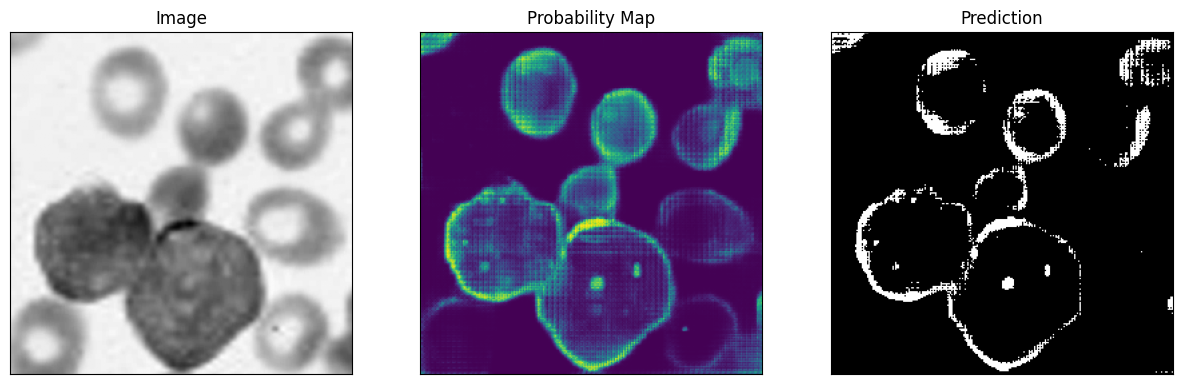

In [39]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
random_array = patches[i, j]


single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

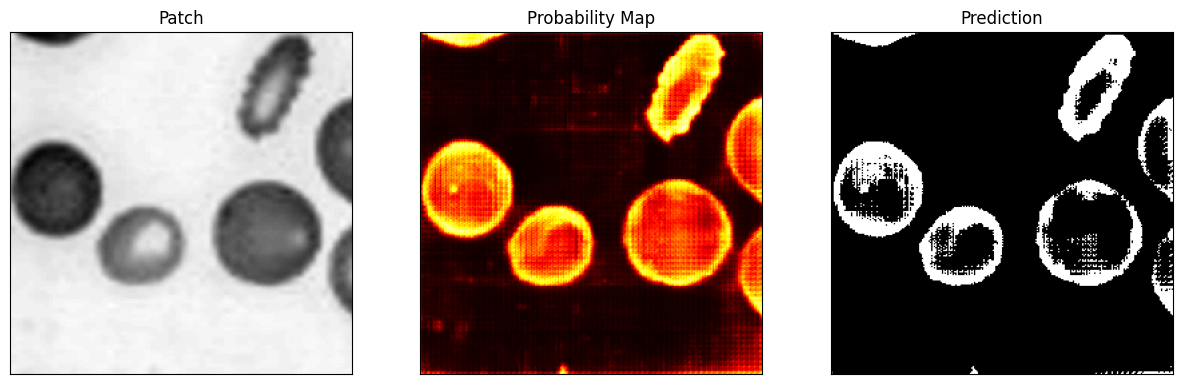

In [ ]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchvision import transforms
from patchify import patchify


image_path = "/content/Original/Pre/WBC-Malignant-Pre-005.jpg"
test_image = Image.open(image_path).convert("RGB")  # Ensure RGB format


test_image = test_image.resize((1024, 768))


test_image_np = np.array(test_image)


if test_image_np.ndim == 3:
    test_image_np = cv2.cvtColor(test_image_np, cv2.COLOR_RGB2GRAY)


patches = patchify(test_image_np, (256, 256), step=256)


i, j = 1, 2
selected_patch = patches[i, j]


single_patch = Image.fromarray(selected_patch)


grid_size = 10
x = np.linspace(0, 255, grid_size)
y = np.linspace(0, 255, grid_size)
xv, yv = np.meshgrid(x, y)

input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv.tolist(), yv.tolist())]
input_points = torch.tensor(input_points).view(1, 1, grid_size * grid_size, 2)


inputs = processor(single_patch, input_points=input_points, return_tensors="pt")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {k: v.to(device) for k, v in inputs.items()}


my_mito_model.eval()


with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)


single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))


single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))


axes[0].imshow(np.array(single_patch), cmap='gray')
axes[0].set_title("Patch")


axes[1].imshow(single_patch_prob, cmap='hot')
axes[1].set_title("Probability Map")


axes[2].imshow(single_patch_prediction, cmap='gray')
axes[2].set_title("Prediction")


for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# Show plots
plt.show()


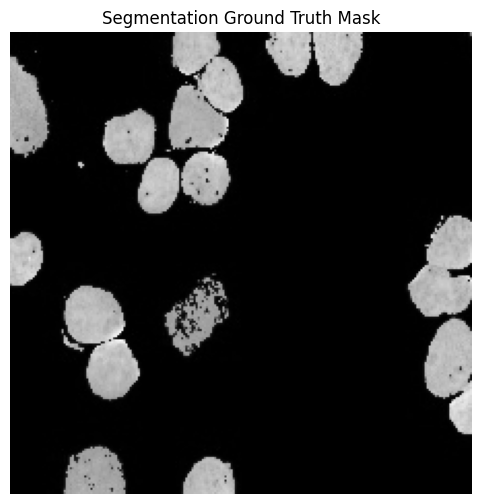

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


image_path = "/content/Segmented/Pre/WBC-Malignant-Pre-005.jpg"
mask = Image.open(image_path).convert("L")  


mask_np = np.array(mask)


plt.figure(figsize=(6,6))
plt.imshow(mask_np, cmap="gray")  
plt.axis("off")
plt.title("Segmentation Ground Truth Mask")
plt.show()


Patch (0, 0) - Raw Output Min: -3.1233458518981934, Max: -0.43919819593429565
Patch (0, 0) - Prob Map Min: 0.0421544648706913, Max: 0.39193204045295715


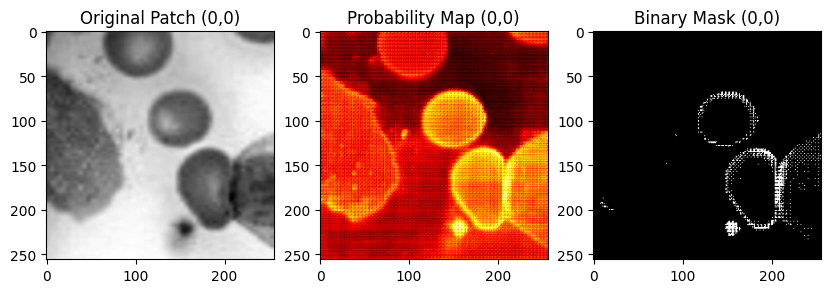

Patch (0, 1) - Raw Output Min: -2.7374918460845947, Max: -0.29807424545288086
Patch (0, 1) - Prob Map Min: 0.06079696863889694, Max: 0.426028311252594


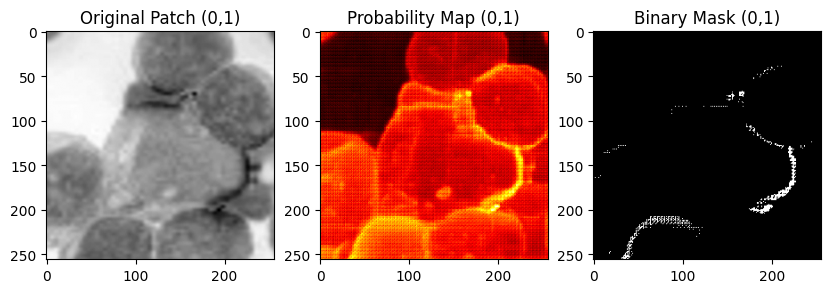

Patch (0, 2) - Raw Output Min: -2.863698720932007, Max: -0.30481263995170593
Patch (0, 2) - Prob Map Min: 0.053977519273757935, Max: 0.42438140511512756
Patch (0, 3) - Raw Output Min: -1.8995916843414307, Max: -0.4518822729587555
Patch (0, 3) - Prob Map Min: 0.13015469908714294, Max: 0.3889133036136627
Patch (1, 0) - Raw Output Min: -4.889224052429199, Max: -1.1029694080352783
Patch (1, 0) - Prob Map Min: 0.0074710245244205, Max: 0.24918393790721893
Patch (1, 1) - Raw Output Min: -2.5458059310913086, Max: -0.4925291836261749
Patch (1, 1) - Prob Map Min: 0.07270875573158264, Max: 0.3792979419231415
Patch (1, 2) - Raw Output Min: -2.3153061866760254, Max: -0.31391817331314087
Patch (1, 2) - Prob Map Min: 0.08986321836709976, Max: 0.4221586287021637
Patch (1, 3) - Raw Output Min: -3.2934494018554688, Max: -0.8829669952392578
Patch (1, 3) - Prob Map Min: 0.035796601325273514, Max: 0.2925633192062378
Patch (2, 0) - Raw Output Min: -2.3329241275787354, Max: -0.2904837727546692
Patch (2, 0) -

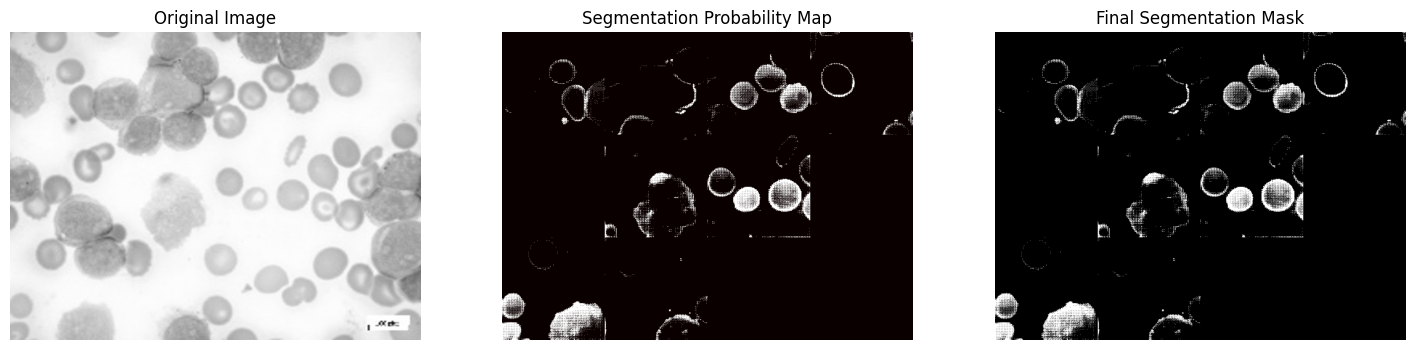

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchvision import transforms
from patchify import patchify, unpatchify


image_path = "/content/Original/Pre/WBC-Malignant-Pre-005.jpg"
test_image = Image.open(image_path).convert("RGB")  # Ensure RGB format
test_image = test_image.resize((1024, 768))  # Resize to (1024, 768)


test_image_np = np.array(test_image)

if test_image_np.ndim == 3:
    test_image_np = cv2.cvtColor(test_image_np, cv2.COLOR_RGB2GRAY)


patches = patchify(test_image_np, (256, 256), step=256)
num_rows, num_cols = patches.shape[:2]


segmented_patches = np.zeros_like(patches)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for i in range(num_rows):
    for j in range(num_cols):
        single_patch = patches[i, j]  
        single_patch_img = Image.fromarray(single_patch) 

        
        inputs = processor(single_patch_img, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}  

        
        with torch.no_grad():
            outputs = my_mito_model(**inputs, multimask_output=False)


        raw_output = outputs.pred_masks.cpu().numpy()
        print(f"Patch ({i}, {j}) - Raw Output Min: {raw_output.min()}, Max: {raw_output.max()}")

     
        single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()


        print(f"Patch ({i}, {j}) - Prob Map Min: {single_patch_prob.min()}, Max: {single_patch_prob.max()}")


        threshold = 0.3 if single_patch_prob.max() < 0.6 else 0.5
        single_patch_prediction = (single_patch_prob > threshold).astype(np.uint8)


        segmented_patches[i, j] = single_patch_prediction


        if i == 0 and j < 2:  
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(single_patch, cmap='gray')
            plt.title(f"Original Patch ({i},{j})")

            plt.subplot(1, 3, 2)
            plt.imshow(single_patch_prob, cmap='hot')
            plt.title(f"Probability Map ({i},{j})")

            plt.subplot(1, 3, 3)
            plt.imshow(single_patch_prediction, cmap='gray')
            plt.title(f"Binary Mask ({i},{j})")

            plt.show()


print("Segmented Patches - Min:", segmented_patches.min(), "Max:", segmented_patches.max())


segmented_image = unpatchify(segmented_patches, test_image_np.shape)


print("Final Segmented Image - Min:", segmented_image.min(), "Max:", segmented_image.max())


fig, axes = plt.subplots(1, 3, figsize=(18, 6))


axes[0].imshow(test_image_np, cmap='gray')
axes[0].set_title("Original Image")


axes[1].imshow(segmented_image, cmap='hot')
axes[1].set_title("Segmentation Probability Map")


axes[2].imshow(segmented_image, cmap='gray')
axes[2].set_title("Final Segmentation Mask")


for ax in axes:
    ax.axis("off")


plt.show()


Patch (0, 0) - Raw Output Min: -3.1233458518981934, Max: -0.43919819593429565
Patch (0, 0) - Prob Map Min: 0.0421544648706913, Max: 0.39193204045295715


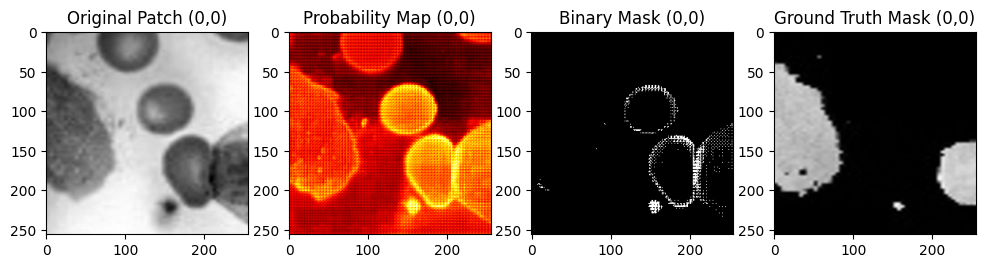

Patch (0, 1) - Raw Output Min: -2.7374918460845947, Max: -0.29807424545288086
Patch (0, 1) - Prob Map Min: 0.06079696863889694, Max: 0.426028311252594


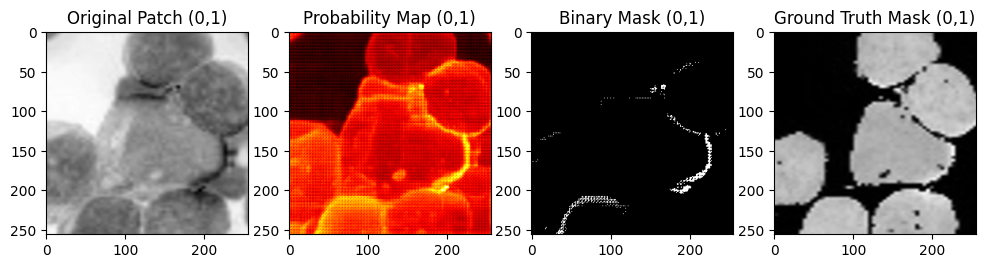

Patch (0, 2) - Raw Output Min: -2.863698720932007, Max: -0.30481263995170593
Patch (0, 2) - Prob Map Min: 0.053977519273757935, Max: 0.42438140511512756
Patch (0, 3) - Raw Output Min: -1.8995916843414307, Max: -0.4518822729587555
Patch (0, 3) - Prob Map Min: 0.13015469908714294, Max: 0.3889133036136627
Patch (1, 0) - Raw Output Min: -4.889224052429199, Max: -1.1029694080352783
Patch (1, 0) - Prob Map Min: 0.0074710245244205, Max: 0.24918393790721893
Patch (1, 1) - Raw Output Min: -2.5458059310913086, Max: -0.4925291836261749
Patch (1, 1) - Prob Map Min: 0.07270875573158264, Max: 0.3792979419231415
Patch (1, 2) - Raw Output Min: -2.3153061866760254, Max: -0.31391817331314087
Patch (1, 2) - Prob Map Min: 0.08986321836709976, Max: 0.4221586287021637
Patch (1, 3) - Raw Output Min: -3.2934494018554688, Max: -0.8829669952392578
Patch (1, 3) - Prob Map Min: 0.035796601325273514, Max: 0.2925633192062378
Patch (2, 0) - Raw Output Min: -2.3329241275787354, Max: -0.2904837727546692
Patch (2, 0) -

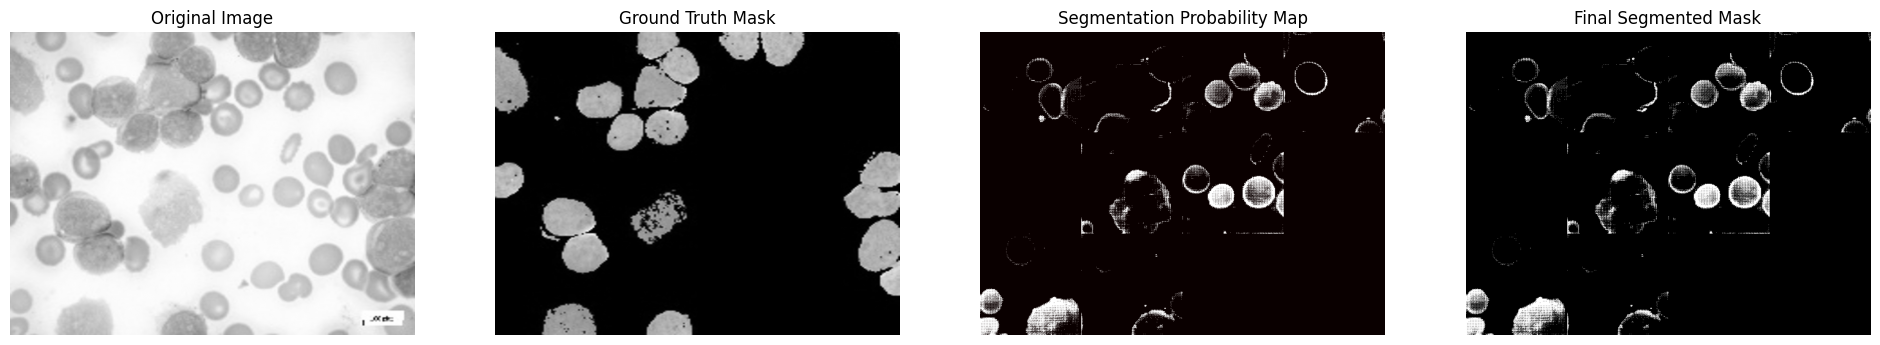

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchvision import transforms
from patchify import patchify, unpatchify


image_path = "/content/Original/Pre/WBC-Malignant-Pre-005.jpg"
mask_path = "/content/Segmented/Pre/WBC-Malignant-Pre-005.jpg"  


test_image = Image.open(image_path).convert("RGB") 
test_image = test_image.resize((1024, 768))  


ground_truth_mask = Image.open(mask_path).convert("L")
ground_truth_mask = ground_truth_mask.resize((1024, 768))

test_image_np = np.array(test_image)
ground_truth_mask_np = np.array(ground_truth_mask)


if test_image_np.ndim == 3:
    test_image_np = cv2.cvtColor(test_image_np, cv2.COLOR_RGB2GRAY)

patches = patchify(test_image_np, (256, 256), step=256)
num_rows, num_cols = patches.shape[:2]


segmented_patches = np.zeros_like(patches)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for i in range(num_rows):
    for j in range(num_cols):
        single_patch = patches[i, j]  
        single_patch_img = Image.fromarray(single_patch)  

        # Prepare input for the model
        inputs = processor(single_patch_img, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}  

        
        with torch.no_grad():
            outputs = my_mito_model(**inputs, multimask_output=False)

        
        raw_output = outputs.pred_masks.cpu().numpy()
        print(f"Patch ({i}, {j}) - Raw Output Min: {raw_output.min()}, Max: {raw_output.max()}")

        
        single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()

        
        print(f"Patch ({i}, {j}) - Prob Map Min: {single_patch_prob.min()}, Max: {single_patch_prob.max()}")

        
        threshold = 0.3 if single_patch_prob.max() < 0.6 else 0.5
        single_patch_prediction = (single_patch_prob > threshold).astype(np.uint8)

        
        segmented_patches[i, j] = single_patch_prediction

        
        if i == 0 and j < 2:  
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 4, 1)
            plt.imshow(single_patch, cmap='gray')
            plt.title(f"Original Patch ({i},{j})")

            plt.subplot(1, 4, 2)
            plt.imshow(single_patch_prob, cmap='hot')
            plt.title(f"Probability Map ({i},{j})")

            plt.subplot(1, 4, 3)
            plt.imshow(single_patch_prediction, cmap='gray')
            plt.title(f"Binary Mask ({i},{j})")

            plt.subplot(1, 4, 4)
            plt.imshow(ground_truth_mask_np[i*256:(i+1)*256, j*256:(j+1)*256], cmap='gray')
            plt.title(f"Ground Truth Mask ({i},{j})")

            plt.show()


print("Segmented Patches - Min:", segmented_patches.min(), "Max:", segmented_patches.max())


segmented_image = unpatchify(segmented_patches, test_image_np.shape)


print("Final Segmented Image - Min:", segmented_image.min(), "Max:", segmented_image.max())


fig, axes = plt.subplots(1, 4, figsize=(24, 6))


axes[0].imshow(test_image_np, cmap='gray')
axes[0].set_title("Original Image")


axes[1].imshow(ground_truth_mask_np, cmap='gray')
axes[1].set_title("Ground Truth Mask")


axes[2].imshow(segmented_image, cmap='hot')
axes[2].set_title("Segmentation Probability Map")


axes[3].imshow(segmented_image, cmap='gray')
axes[3].set_title("Final Segmented Mask")


for ax in axes:
    ax.axis("off")


plt.show()
